In [2]:
!pip install transformers
!pip install sentencepiece

In [3]:
import os
import json
from google.colab import drive

drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/Kaggle/DetectAIGeneratedTextUsingBERT/notebook")

f = open("../../../kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

# !mkdir ../data
# !kaggle competitions download -c llm-detect-ai-generated-text -p ../data
# !unzip ../data/llm-detect-ai-generated-text -d ../data

Mounted at /content/drive


In [4]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings


from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

Current device is: cuda
mkdir: cannot create directory ‘output’: File exists


In [5]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.15.0
transformers.__version__: 4.35.2


In [6]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 16
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 2e-5
    ENCODER_LR = 2e-5
    EPOCHS = 5
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=1000
    MAX_LEN = 512
    MIN_LR = 1e-6
    MODEL = "microsoft/deberta-v3-base"
    NUM_CYCLES = 0.5
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'cosine' # ['linear', 'cosine']
    SEED = 27
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    WANDB = False
    WEIGHT_DECAY = 0.01


class paths:
    # OUTPUT_DIR = "/kaggle/working/output"
    # EXTERNAL_DATA = "/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv"
    # TRAIN_PROMPTS = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
    # TRAIN_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
    # TEST_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
    OUTPUT_DIR = "../data/output"
    EXTERNAL_DATA = "../data/daigt/daigt_external_dataset.csv"
    TRAIN_PROMPTS = "../data/train_prompts.csv"
    TRAIN_ESSAYS = "../data/train_essays.csv"
    TEST_ESSAYS = "../data/test_essays.csv"

if config.DEBUG:
    config.EPOCHS = 2
    config.TRAIN_FOLDS = [0]

In [7]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items()
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler


def get_score(y_trues, y_preds):
    score = roc_auc_score(y_trues, y_preds)
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def sep():
    print("-"*100)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

LOGGER = get_logger()
seed_everything(seed=config.SEED)

In [8]:
train_df = pd.read_csv(paths.TRAIN_ESSAYS, sep=',')
external_df = pd.read_csv(paths.EXTERNAL_DATA, sep=',')
train_prompts = pd.read_csv(paths.TRAIN_PROMPTS, sep=',')
print(f"Train essays dataframe has shape: {train_df.shape}"), sep()
print(f"External essays dataframe has shape: {external_df.shape}"), sep()
print(f"Train prompts dataframe has shape: {train_prompts.shape}"), sep()
display(train_df.head())
display(external_df.head())
display(train_prompts.head())

Train essays dataframe has shape: (1378, 4)
----------------------------------------------------------------------------------------------------
External essays dataframe has shape: (2421, 4)
----------------------------------------------------------------------------------------------------
Train prompts dataframe has shape: (2, 4)
----------------------------------------------------------------------------------------------------


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident..."
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [9]:
external_df1 = external_df[["id", "source_text"]]
external_df1.columns = ["id", "text"]
external_df1['text'] = external_df['text'].str.replace('\n', '')
external_df1["generated"] = 1
external_df2 = external_df[["id", "text"]]
external_df2["generated"] = 0

train_df.drop(columns=["prompt_id"],inplace=True)
train_df = pd.concat([train_df, external_df1, external_df2])
train_df.reset_index(inplace=True, drop=True)
print(f"Train dataframe has shape: {train_df.shape}"), sep()
train_df.head()

Train dataframe has shape: (6220, 3)
----------------------------------------------------------------------------------------------------


,id,text,generated
0,0059830c,Cars. Cars have been around since they became ...,0
1,005db917,Transportation is a large necessity in most co...,0
2,008f63e3,"""America's love affair with it's vehicles seem...",0
3,00940276,How often do you ride in a car? Do you drive a...,0
4,00c39458,Cars are a wonderful thing. They are perhaps o...,0


In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
X = train_df.loc[:, train_df.columns != "generated"]
y = train_df.loc[:, train_df.columns == "generated"]

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i

print(train_df.groupby("fold")["generated"].value_counts())
train_df.head()

fold  generated
0.0   0            760
      1            484
1.0   0            759
      1            485
2.0   0            759
      1            485
3.0   0            759
      1            485
4.0   0            759
      1            485
Name: generated, dtype: int64


,id,text,generated,fold
0,0059830c,Cars. Cars have been around since they became ...,0,0.0
1,005db917,Transportation is a large necessity in most co...,0,0.0
2,008f63e3,"""America's love affair with it's vehicles seem...",0,0.0
3,00940276,How often do you ride in a car? Do you drive a...,0,0.0
4,00c39458,Cars are a wonderful thing. They are perhaps o...,0,0.0


In [11]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

(…)deberta-v3-base/resolve/main/config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


  0%|          | 0/6220 [00:00<?, ?it/s]

max_len: 512
INFO:__main__:max_len: 512


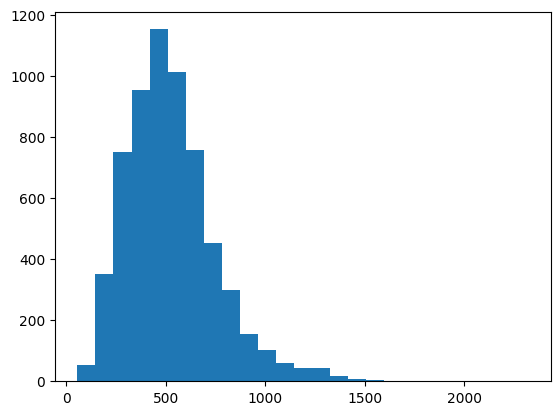

In [12]:
lengths = []
tqdm_loader = tqdm(train_df['text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)

# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [13]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text,
        return_tensors=None,
        add_special_tokens=True,
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch.
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['generated'].values
        self.tokenizer = tokenizer
        self.text_ids = df['id'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.float) # TODO: check dtypes
        output["ids"] = self.text_ids[item]
        return output

In [14]:
# if config.DEBUG:
#     # ======== SPLIT ==========
#     fold = 0
#     train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
#     valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['generated'].values

#     # ======== DATASETS ==========
#     train_dataset = CustomDataset(config, train_folds, tokenizer)
#     valid_dataset = CustomDataset(config, valid_folds, tokenizer)

#     # ======== DATALOADERS ==========
#     train_loader = DataLoader(train_dataset,
#                               batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
#                               shuffle=True,
#                               num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=config.BATCH_SIZE_VALID,
#                               shuffle=False,
#                               num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

#     # === Let's check one sample ===
#     sample = train_dataset[0]
#     print(f"Encoding keys: {sample.keys()} \n")
#     print(sample)

In [15]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        # Load config by inferencing it from the model name.
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)

        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()

        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
        self._init_weights(self.head)

    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.head(feature)
        return output

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0

    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader),
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] train loss": losses.val,
                           f"[fold_{fold}] lr": scheduler.get_lr()[0]})

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            ids = batch.pop("ids")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] val loss": losses.val})

    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["ids"] = ids
    return losses.avg, prediction_dict

In [17]:
# def train_loop(folds, fold):

#     LOGGER.info(f"========== Fold: {fold} training ==========")

#     # ======== SPLIT ==========
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)

#     valid_labels = valid_folds['generated'].values

#     # ======== DATASETS ==========
#     train_dataset = CustomDataset(config, train_folds, tokenizer)
#     valid_dataset = CustomDataset(config, valid_folds, tokenizer)

#     # ======== DATALOADERS ==========
#     train_loader = DataLoader(train_dataset,
#                               batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
#                               shuffle=True,
#                               pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=config.BATCH_SIZE_VALID,
#                               shuffle=False,
#                               pin_memory=True, drop_last=False)

#     # ======== MODEL ==========
#     model = CustomModel(config, config_path=None, pretrained=True)
#     torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
#     model.to(device)

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=config.ENCODER_LR,
#                                                 decoder_lr=config.DECODER_LR,
#                                                 weight_decay=config.WEIGHT_DECAY)
#     optimizer = AdamW(optimizer_parameters,
#                       lr=config.ENCODER_LR,
#                       eps=config.EPS,
#                       betas=config.BETAS)

#     scheduler = OneCycleLR(
#         optimizer,
#         max_lr=1e-5,
#         epochs=config.EPOCHS,
#         steps_per_epoch=len(train_loader),
#         pct_start=0.1,
#         anneal_strategy="cos",
#         final_div_factor=100,
#     )

#     # ======= LOSS ==========
#     criterion = nn.BCEWithLogitsLoss()

#     best_score = -np.inf
#     # ====== ITERATE EPOCHS ========
#     for epoch in range(config.EPOCHS):

#         start_time = time.time()

#         # ======= TRAIN ==========
#         avg_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # ======= EVALUATION ==========
#         avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
#         predictions = prediction_dict["predictions"]
#         # ======= SCORING ==========
#         score = get_score(valid_labels, sigmoid(predictions))

#         elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

#         if config.WANDB:
#             wandb.log({f"[fold_{fold}] epoch": epoch+1,
#                        f"[fold_{fold}] avg_train_loss": avg_loss,
#                        f"[fold_{fold}] avg_val_loss": avg_val_loss,
#                        f"[fold_{fold}] score": score})

#         if score > best_score:
#             best_score = score
#             LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
#             torch.save(model.state_dict(),
#                         paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")
#             best_model_predictions = predictions

#     valid_folds["preds"] = best_model_predictions

#     torch.cuda.empty_cache()
#     gc.collect()

#     return valid_folds

In [18]:
# if __name__ == '__main__':
#     def get_result(oof_df):
#         labels = oof_df["generated"].values
#         preds = oof_df["preds"].values
#         score = get_score(labels, preds)
#         LOGGER.info(f'Score: {score:<.4f}')

#     if config.TRAIN:
#         oof_df = pd.DataFrame()
#         for fold in range(config.FOLDS):
#             if fold == 0:
#                 _oof_df = train_loop(train_df, fold)
#                 oof_df = pd.concat([oof_df, _oof_df])
#                 LOGGER.info(f"========== Fold: {fold} result ==========")
#                 get_result(_oof_df)
#         oof_df = oof_df.reset_index(drop=True)
#         LOGGER.info(f"========== CV ==========")
#         get_result(oof_df)
#         oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
#     if config.WANDB:
#         wandb.finish()

# Debug All process


In [19]:
# for fold in train_df['fold'].unique():

#     LOGGER.info(f"========== Fold: {fold} training ==========")

#     # ======== SPLIT ==========
#     train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
#     valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

#     valid_labels = valid_folds['generated'].values

#     print(f"train_folds shape:{train_folds.shape}")
#     print(f"valid_folds shape:{valid_folds.shape}")

#     # ======== DATASETS ==========
#     train_dataset = CustomDataset(config, train_folds, tokenizer)
#     valid_dataset = CustomDataset(config, valid_folds, tokenizer)

#     # ======== DATALOADERS ==========
#     train_loader = DataLoader(train_dataset,
#                                 batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
#                                 shuffle=True,
#                                 # num_workers=config.NUM_WORKERS,
#                                 pin_memory=True,
#                                 drop_last=True
#                             )
#     valid_loader = DataLoader(valid_dataset,
#                                 batch_size=config.BATCH_SIZE_VALID,
#                                 shuffle=False,
#                                 # num_workers=config.NUM_WORKERS,
#                                 pin_memory=True,
#                                 drop_last=False
#                             )
#     # ======== MODEL ==========
#     model = CustomModel(config, config_path=None, pretrained=True)
#     torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
#     model.to(device)

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=config.ENCODER_LR,
#                                                 decoder_lr=config.DECODER_LR,
#                                                 weight_decay=config.WEIGHT_DECAY)
#     optimizer = AdamW(optimizer_parameters,
#                         lr=config.ENCODER_LR,
#                         eps=config.EPS,
#                         betas=config.BETAS)

#     scheduler = OneCycleLR(
#         optimizer,
#         max_lr=1e-5,
#         epochs=config.EPOCHS,
#         steps_per_epoch=len(train_loader),
#         pct_start=0.1,
#         anneal_strategy="cos",
#         final_div_factor=100,
#     )
#     # ======= LOSS ==========
#     criterion = nn.BCEWithLogitsLoss()

#     best_score = -np.inf
#     # ====== ITERATE EPOCHS ========
#     for epoch in range(config.EPOCHS):

#         start_time = time.time()

#         # ======= TRAIN ==========

#         """One epoch training pass."""
#         model.train() # set model in train mode
#         scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
#         losses = AverageMeter() # initiate AverageMeter to track the loss.
#         start = end = time.time() # track the execution time.
#         global_step = 0

#         # ========== ITERATE OVER TRAIN BATCHES ============
#         with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
#             for step, batch in enumerate(tqdm_train_loader):
#                 inputs = batch.pop("inputs")
#                 labels = batch.pop("labels")
#                 inputs = collate(inputs) # collate inputs
#                 for k, v in inputs.items(): # send each tensor value to `device`
#                     inputs[k] = v.to(device)
#                 labels = labels.to(device) # send labels to `device`
#                 batch_size = labels.size(0)
#                 with torch.cuda.amp.autocast(enabled=config.APEX):
#                     y_preds = model(inputs) # forward propagation pass
#                     loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
#                 if config.GRADIENT_ACCUMULATION_STEPS > 1:
#                     loss = loss / config.GRADIENT_ACCUMULATION_STEPS
#                 losses.update(loss.item(), batch_size) # update loss function tracking
#                 scaler.scale(loss).backward() # backward propagation pass
#                 grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

#                 if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
#                     scaler.step(optimizer) # update optimizer parameters
#                     scaler.update()
#                     optimizer.zero_grad() # zero out the gradients
#                     global_step += 1
#                     if config.BATCH_SCHEDULER:
#                         scheduler.step() # update learning rate
#                 end = time.time() # get finish time

#                 # ========== LOG INFO ==========
#                 if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
#                     print('Epoch: [{0}][{1}/{2}] '
#                         'Elapsed {remain:s} '
#                         'Loss: {loss.avg:.4f} '
#                         'Grad: {grad_norm:.4f}  '
#                         'LR: {lr:.8f}  '
#                         .format(epoch+1, step, len(train_loader),
#                                 remain=timeSince(start, float(step+1)/len(train_loader)),
#                                 loss=losses,
#                                 grad_norm=grad_norm,
#                                 lr=scheduler.get_lr()[0]))
#         avg_loss = losses.avg


#         # ======= EVALUATION ==========

#         model.eval() # set model in evaluation mode
#         losses = AverageMeter() # initiate AverageMeter for tracking the loss.
#         prediction_dict = {}
#         preds = []
#         start = end = time.time() # track the execution time.
#         with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
#             for step, batch in enumerate(tqdm_valid_loader):
#                 inputs = batch.pop("inputs")
#                 labels = batch.pop("labels")
#                 ids = batch.pop("ids")
#                 inputs = collate(inputs) # collate inputs
#                 for k, v in inputs.items():
#                     inputs[k] = v.to(device) # send inputs to device
#                 labels = labels.to(device)
#                 batch_size = labels.size(0)
#                 with torch.no_grad():
#                     y_preds = model(inputs) # forward propagation pass
#                     loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
#                 if config.GRADIENT_ACCUMULATION_STEPS > 1:
#                     loss = loss / config.GRADIENT_ACCUMULATION_STEPS
#                 losses.update(loss.item(), batch_size) # update loss function tracking
#                 preds.append(y_preds.to('cpu').numpy()) # save predictions
#                 end = time.time() # get finish time

#                 # ========== LOG INFO ==========
#                 if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
#                     print('EVAL: [{0}/{1}] '
#                         'Elapsed {remain:s} '
#                         'Loss: {loss.avg:.4f} '
#                         .format(step, len(valid_loader),
#                                 loss=losses,
#                                 remain=timeSince(start, float(step+1)/len(valid_loader))))

#         prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
#         prediction_dict["ids"] = ids
#         avg_val_loss = losses.avg
#         predictions = prediction_dict["predictions"]
#         # ======= SCORING ==========
#         score = roc_auc_score(valid_labels, sigmoid(predictions))

#         elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

#         if score > best_score:
#             best_score = score
#             LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
#             torch.save(model.state_dict(),
#                         paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")
#             best_model_predictions = predictions

#     valid_folds["preds"] = best_model_predictions

#     torch.cuda.empty_cache()
#     gc.collect()

# Validation

In [21]:
for fold in train_df['fold'].unique():
    torch.cuda.empty_cache()
    gc.collect()
    model_path = f"../data/output/microsoft_deberta-v3-base_fold_{fold}_best.pth"

    # ======== SPLIT ==========
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['generated'].values

    print(f"valid_folds shape:{valid_folds.shape}")

    # ======== DATASETS ==========
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    valid_loader = DataLoader(valid_dataset,
                                batch_size=config.BATCH_SIZE_VALID,
                                shuffle=False,
                                # num_workers=config.NUM_WORKERS,
                                pin_memory=True,
                                drop_last=False
                            )
    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

    # ======= EVALUATION ==========

    model.eval() # set model in evaluation mode
    preds = []
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            ids = batch.pop("ids")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
            preds.append(y_preds.to('cpu').numpy()) # save predictions


    preds = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    # ======= SCORING ==========
    score = roc_auc_score(valid_labels, sigmoid(preds))
    print(f"fold:{fold}, score:{score}")
    break
torch.cuda.empty_cache()
gc.collect()

valid_folds shape:(1244, 4)


Validation:   0%|          | 0/78 [00:00<?, ?valid_batch/s]

fold:0.0, score:0.9982927359721618


9

In [33]:
def binarize(x, threshold):
    if x > threshold:
        x = 1
    else:
        x = 0
    return x
valid_folds["pred_label"] = valid_folds["preds"].apply(lambda x: binarize(x, 0.5))

In [34]:
(valid_folds["pred_label"] == valid_folds["generated"]).mean()

0.9590032154340836

In [21]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# from sklearn.metrics import confusion_matrix

def binarize(x, threshold):
    if x > threshold:
        x = 1
    else:
        x = 0
    return x

# # Assuming df is your pandas DataFrame
# oof_df["binary"] = oof_df["preds"].apply(lambda x: binarize(x, 0.5))
# true_labels = oof_df["generated"].values
# predicted_labels = oof_df["binary"].values

# # Get the unique classes from both true and predicted labels
# classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# # Compute the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")